In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# # Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [7]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\fcf795f2-cce9-11ee-89a4-04ecd823af18.jpg'

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [12]:
frame

array([[[200, 201, 198],
        [199, 199, 198],
        [198, 198, 198],
        ...,
        [197, 199, 199],
        [197, 199, 199],
        [197, 199, 199]],

       [[199, 200, 197],
        [199, 199, 198],
        [198, 198, 198],
        ...,
        [198, 200, 200],
        [199, 201, 201],
        [198, 200, 200]],

       [[199, 200, 197],
        [199, 200, 198],
        [198, 199, 197],
        ...,
        [198, 200, 200],
        [198, 200, 200],
        [197, 199, 199]],

       ...,

       [[ 37,  37,  81],
        [ 37,  36,  80],
        [ 38,  35,  80],
        ...,
        [ 44,  38,  93],
        [ 42,  38,  91],
        [ 40,  37,  89]],

       [[ 40,  36,  82],
        [ 39,  36,  82],
        [ 38,  36,  82],
        ...,
        [ 45,  37,  90],
        [ 43,  36,  86],
        [ 42,  36,  84]],

       [[ 39,  35,  81],
        [ 39,  36,  82],
        [ 38,  36,  82],
        ...,
        [ 45,  37,  90],
        [ 42,  35,  85],
        [ 41,  35,  83]]

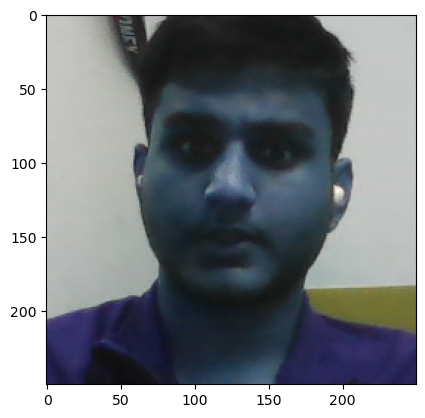

In [13]:
plt.imshow(frame)

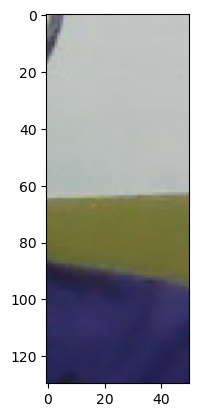

In [14]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [27]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [28]:
dir_test = anchor.as_numpy_iterator()

In [22]:
print(dir_test.next())

b'data\\anchor\\fffe37a9-c4f1-11ee-bbbd-04ecd823af18.jpg'


In [29]:
dir2_test = negative.as_numpy_iterator()

In [30]:
print(dir2_test.next())

b'data\\negative\\Sergio_Vieira_De_Mello_0010.jpg'


In [38]:
dir3_test = positive.as_numpy_iterator()

In [32]:
print(dir3_test.next())

b'data\\negative\\Daniel_Radcliffe_0001.jpg'


In [34]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img 

In [45]:
img=preprocess('data\\anchor\\fffe37a9-c4f1-11ee-bbbd-04ecd823af18.jpg')

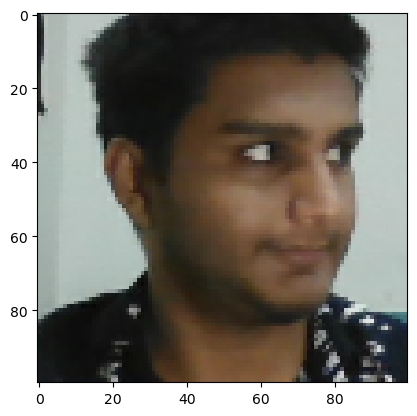

In [46]:
plt.imshow(img)

In [41]:
img2=preprocess('data\\negative\\Sergio_Vieira_De_Mello_0010.jpg')

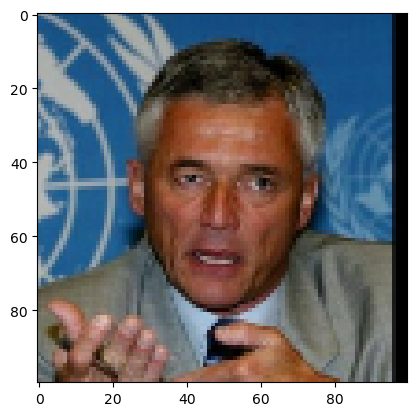

In [47]:
plt.imshow(img2)

In [51]:
img2.numpy().min()

0.0

In [50]:
img2.numpy().max()

0.88529414

In [53]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [140]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [141]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [142]:
samples = data.as_numpy_iterator()

In [143]:
example = samples.next()

In [144]:
example

(b'data\\anchor\\c5577d34-c4f1-11ee-a95a-04ecd823af18.jpg',
 b'data\\positive\\bf7e87eb-c4f1-11ee-9ae4-04ecd823af18.jpg',
 1.0)

In [145]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [146]:
res = preprocess_twin(*example)

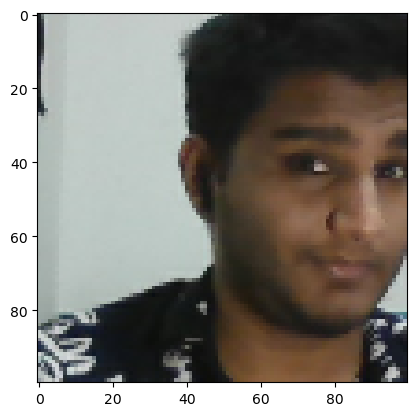

In [147]:
plt.imshow(res[1])

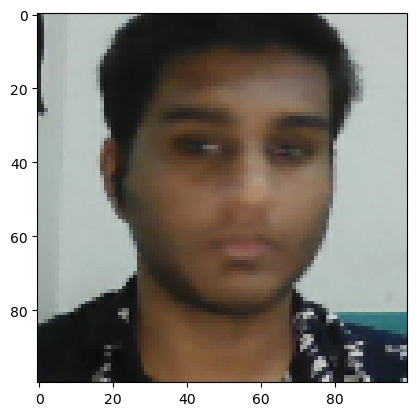

In [148]:
plt.imshow(res[0])

In [149]:
res[2]

1.0

In [161]:
# # Build dataloader pipeline
# data = data.map(preprocess_twin)

In [162]:

data = data.cache()
data = data.shuffle(buffer_size=1024)

In [164]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [165]:
samples = data.as_numpy_iterator()

In [166]:
example = samples.next()
example

(array([[[0.14068627, 0.14460784, 0.16029412],
         [0.43137255, 0.43823528, 0.44509804],
         [0.7004902 , 0.71617645, 0.7142157 ],
         ...,
         [0.75686276, 0.78039217, 0.77254903],
         [0.75759804, 0.78112745, 0.7732843 ],
         [0.7607843 , 0.78431374, 0.7764706 ]],
 
        [[0.11838235, 0.12034313, 0.13799019],
         [0.3617647 , 0.36789215, 0.38284314],
         [0.6985294 , 0.7134804 , 0.71813726],
         ...,
         [0.7607843 , 0.78431374, 0.7764706 ],
         [0.75784314, 0.78137255, 0.7735294 ],
         [0.7607843 , 0.78431374, 0.7764706 ]],
 
        [[0.10294118, 0.09901961, 0.11960784],
         [0.2634804 , 0.2629902 , 0.28088236],
         [0.71911764, 0.7252451 , 0.73284316],
         ...,
         [0.7607843 , 0.78431374, 0.7764706 ],
         [0.75784314, 0.78137255, 0.7735294 ],
         [0.7607843 , 0.78431374, 0.7764706 ]],
 
        ...,
 
        [[0.08333334, 0.09509804, 0.12058824],
         [0.07352941, 0.08602941, 0.10416

In [199]:
len(example)

3

In [215]:
samp=samples.next()

In [216]:
# samp

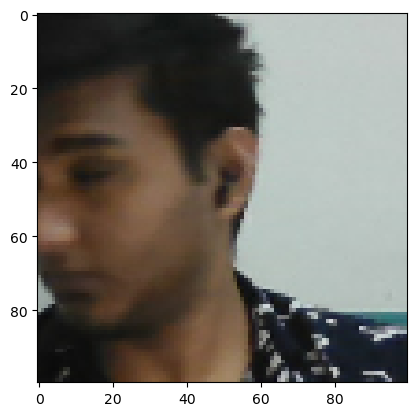

In [217]:
plt.imshow(samp[0])

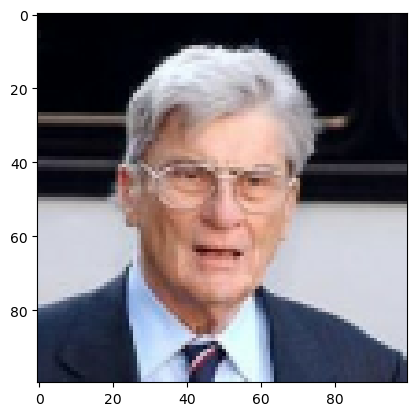

In [218]:
plt.imshow(samp[1])

In [219]:
samp[2]

0.0

In [220]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [221]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [223]:
train_samples=train_data.as_numpy_iterator()

In [224]:
train_sam=train_samples.next()

In [226]:
len(train_sam[0])

16

In [227]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)